In [1]:
import pysam
import re
import pandas as pd
import numpy as np

In [2]:
def get_cg_reference(lst_read_pos, s, e):
    """
    lst_read_pos = [('C', 0), ('T', 1), ('G', 2), ('T', 3), (...)]
    s: start index
    e: end index
    """
    res = [x for x in lst_read_pos if x[1] in range(s, e)]
    return res
    
    
def get_cg_idx_probability_from_ml(read_sequence, ml_tag, thresh):
    """
    Input:
    read_sequence: read.query_sequence (not read.query_alignment_sequence)
    ml_tag: list(read.get_tag('ML'))
    
    Output:
    cg_idx_mfreq: list
    
    Example output:
    cg_idx_mfreq = [(38, 0, 0.2), (41, 0, 0.3), (61, 0, 45), (85, 0, 0.9), (169, 0, 0.56)]
    first item in tuple == index of the C position
    second item in tuple == 0/unmethylated or 1/methylated
    third item == mod prob
    """
    # transform ml to probabilities
    ml_prob = [round(x/256, 2) for x in ml_tag]
    # if probability >= 0.5, then it's considered methylated
    ml_res = [0 if x<thresh else 1 for x in ml_prob]
    # find all C indexes with CG
    cg_idx = [m.start(0) for m in re.finditer("CG", read_sequence)]
    cg_idx_mfreq = list(zip(cg_idx, ml_res, ml_prob)) # add mods
    return cg_idx_mfreq


def process_read(read, idx_flank_left=47, idx_flank_right=57, thresh=0.5):
    """
    CG will be in positions 51,52 
    
    Input: 
    read: pysam AlignedSegment object
    idx_flank_left: 51-n left flanking bases (default: 47)
    idx_flank_right: 52+n right flanking bases (default: 57)
    """
    # get the C index with methylation frequency information
    cg_idx_mfreq = get_cg_idx_probability_from_ml(
        read.query_sequence, list(read.get_tag('ML')), thresh
    )
    # print(cg_idx_mfreq)
    
    # finding the haplotype of the read
    seq = [[x] for x in read.query_sequence] 
    for idx, base in enumerate(seq):
        nt = base[0]
        for i in cg_idx_mfreq:
            if i[0] == idx:
                base.append(str(i[1]))
                base.append(str(i[2])) # add mods
        if len(base) == 1:
            base.append(nt)
            base.append('-') # add mods
        else:
            if base[1] == '0':
                base[1] = 'T'
            else:
                base[1] = 'C'
    # print(seq)
    
    # subset by the portion of the read that aligned to the reference
    seq_align = seq[read.query_alignment_start:read.query_alignment_end]
    # print(seq_align)
    
    # zip with reference positions, so we can find the CG in position 51,52
    r = list(zip(seq_align, read.get_reference_positions()))
    # print(r)
    
    # subset by the target flanking region
    res = [x for x in r if x[1] in range(idx_flank_left, idx_flank_right)]
    res = [[x[0][0], x[0][1], x[0][2], x[1]] for x in res] # add mods
    # print(res)
    
    # data wrangling
    df_res = pd.DataFrame(res, columns = ['read', 'haplotype', 'mods', 'pos']) # add mods
    df_res['read_name'] = read.query_name
    df_res['pos'] = df_res['pos'].astype(str)
    df_res = df_res.groupby(['read_name'], as_index=False).agg({
        'read': "".join,
        'haplotype': "".join,
        'mods': ",".join, 
        'pos': ",".join
    })
    # df_res['reverse'] = read.is_reverse
    # df_res['flag'] = read.flag # no need

    return df_res

In [3]:
def extract_mod_scores(df):
    cpg = []
    denovo = []

    for i in df.mods:
        mod_scores = i.split(",")
        if mod_scores[4] != "-":
            cpg.append(mod_scores[4])
        del mod_scores[4]
        for j in mod_scores:
            if j != "-":
                denovo.append(j)  
    
    cpg = [float(x) for x in cpg]
    denovo = [float(x) for x in denovo]
    return cpg, denovo

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

def plotter(cpg, denovo, desc):
    n, bins, patches = plt.hist(x=cpg, bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85, label='51,52 CpG Site')
    plt.hist(x=denovo, bins='auto', color='orange',
                                alpha=0.7, rwidth=0.85, label='denovo C')
    plt.grid(axis='y', alpha=0.75)
    plt.axvline(x = 0.5, color = 'r', linestyle = ':', label="threshold 0.5") 
    plt.axvline(x = 0.3, color = 'r', linestyle = ':', label="threshold 0.3") 
    plt.axvline(x = 0.1, color = 'r', linestyle = ':', label="threshold 0.1") 
    plt.xlabel('Value')
    plt.xticks(np.arange(0, 1.05, 0.05), rotation=45)
    plt.ylabel('Frequency')
    plt.title('Mod Score Distribution for 51,52 CpG Site and Denovo C')
    plt.suptitle(desc)
    #plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 11 if maxfreq % 10 else maxfreq + 10)

In [12]:
def df_generation(in_file, outfile):
    bamin = pysam.AlignmentFile(in_file, "rb")

    df_reads = []
    count = 0
    for read in bamin:
        if read.flag in [0, 16]:
            try:
                # Change parameters here:
                # idx_flank_left=47, index for slicing left flank
                # idx_flank_right=57, remember python isn't inclusive
                # thresh=0.5, threshold for calling a C methylated (>=0.5) or unmethylated (<0.5)
                df_reads.append(process_read(read, idx_flank_left=47, idx_flank_right=57, thresh=0.1))
            except:
                count+=1

    df = pd.concat(df_reads, axis=0)
    df = df.sort_values('read_name')
    df.to_csv(out_file, sep='\t', index=False)
    return df

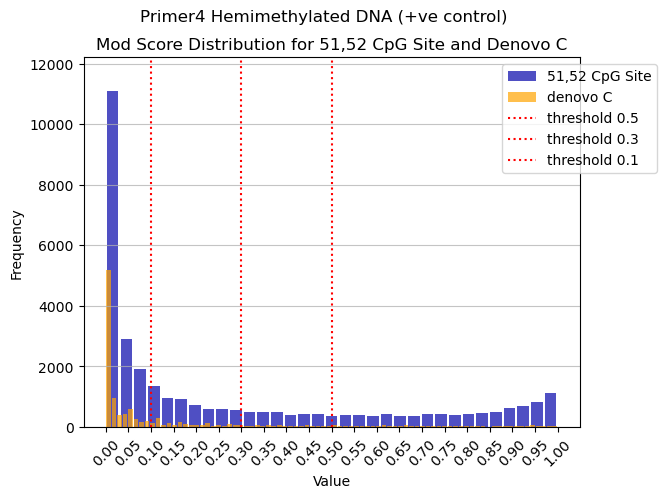

In [13]:
in_file = "/Users/nguyec27/Downloads/PacBio Methylation Mapped BAM/control-mapped.bam"
out_file = 'pacbio_flanking_region_with_mods.tsv'
control_bam = df_generation(in_file, out_file)
cpg_control, denovo_control = extract_mod_scores(control_bam)

plotter(cpg_control, denovo_control, "Primer4 Hemimethylated DNA (+ve control)")

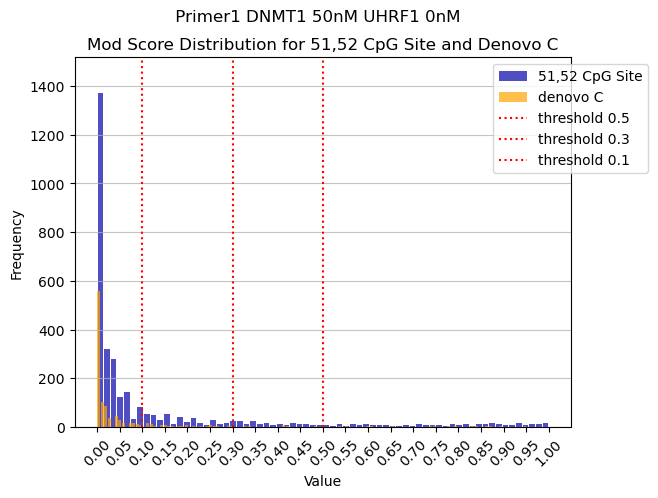

In [14]:
in_file = "/Users/nguyec27/Downloads/PacBio Methylation Mapped BAM/DNMT1_group1-mapped.bam"
out_file = 'pacbio_flanking_region_with_mods_DNMT1_group1-mapped.tsv'
DNMT1_group1_bam = df_generation(in_file, out_file)
cpg_DNMT1_group1, denovo_DNMT1_group1 = extract_mod_scores(DNMT1_group1_bam)

plotter(cpg_DNMT1_group1, denovo_DNMT1_group1, " Primer1 DNMT1 50nM UHRF1 0nM")

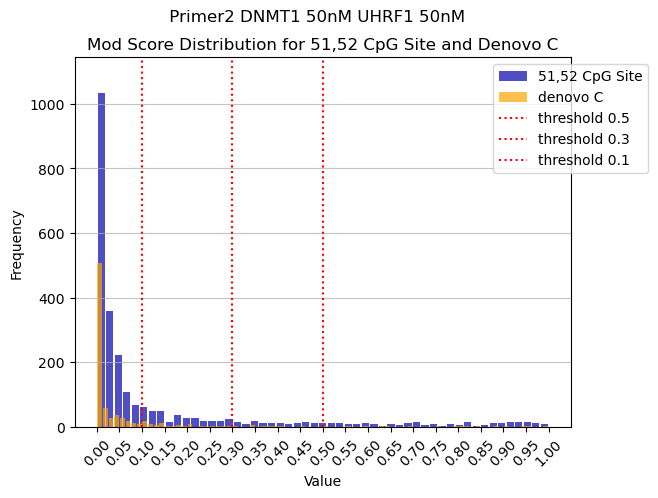

In [15]:
in_file = "/Users/nguyec27/Downloads/PacBio Methylation Mapped BAM/DNMT1_group2-mapped.bam"
out_file = 'pacbio_flanking_region_with_mods_DNMT1_group2-mapped.tsv'
DNMT1_group2_bam = df_generation(in_file, out_file)
cpg_DNMT1_group2, denovo_DNMT1_group2 = extract_mod_scores(DNMT1_group2_bam)

plotter(cpg_DNMT1_group2, denovo_DNMT1_group2, " Primer2 DNMT1 50nM UHRF1 50nM")

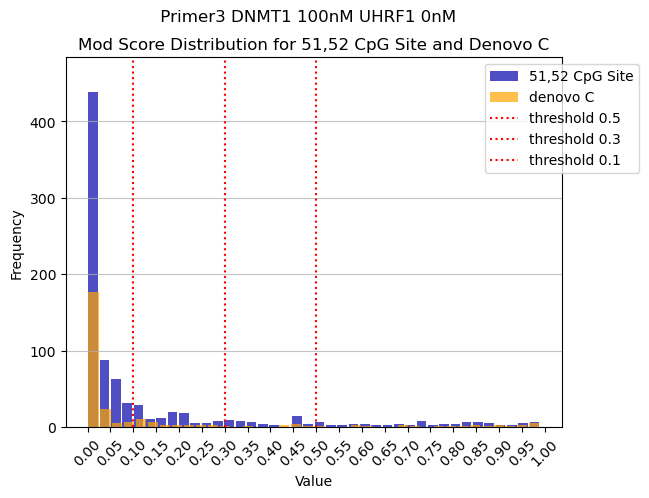

In [16]:
in_file = "/Users/nguyec27/Downloads/PacBio Methylation Mapped BAM/DNMT1_group3-mapped.bam"
out_file = 'pacbio_flanking_region_with_mods_DNMT1_group3-mapped.tsv'
DNMT1_group3_bam = df_generation(in_file, out_file)
cpg_DNMT1_group3, denovo_DNMT1_group3 = extract_mod_scores(DNMT1_group3_bam)

plotter(cpg_DNMT1_group3, denovo_DNMT1_group3, " Primer3 DNMT1 100nM UHRF1 0nM")

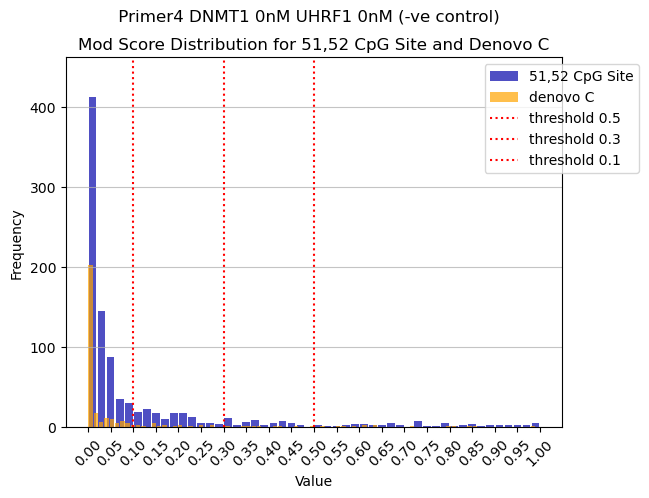

In [17]:
in_file = "/Users/nguyec27/Downloads/PacBio Methylation Mapped BAM/DNMT1_group4-mapped.bam"
out_file = 'pacbio_flanking_region_with_mods_DNMT1_group4-mapped.tsv'
DNMT1_group4_bam = df_generation(in_file, out_file)
cpg_DNMT1_group4, denovo_DNMT1_group4 = extract_mod_scores(DNMT1_group4_bam)

plotter(cpg_DNMT1_group4, denovo_DNMT1_group4, " Primer4 DNMT1 0nM UHRF1 0nM (-ve control)")